## Logistic AR Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example we have Bernoulli base distribution with Logit Link function and covariance matrix $\Gamma$ structured under AR covariance with $\rho = 0.9, \sigma^2 = 0.1$

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
βtrue = ones(p)
σ2true = [0.1]
ρtrue = [0.9]

# generate data
trueparams = [βtrue; σ2true; ρtrue] #hold true parameters

#simulation parameters
samplesizes = [1000; 10000; 50000]
ns = [5; 10; 20; 50]
nsims = 50

50

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_logistic_AR50reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_logistic_AR50reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_logistic_AR50reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_logistic_AR50reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


600-element Vector{Float64}:
   1.892342751
   0.169272335
   0.15695689
   0.248287004
   0.188995608
   0.190701837
   0.196185067
   0.267063821
   0.246493485
   0.207082051
   0.208841569
   0.234890864
   0.189928634
   ⋮
  91.739845591
  63.192130659
  86.475203317
 102.163822306
  75.994718271
 116.227160683
  94.951015
  61.234621417
  87.405961815
  75.670840345
  73.085693166
  90.227366354

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, σ2mse = σ2MseResult, ρmse = ρMseResult,
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,5,0.252209,0.034657,5000,0.217552,0.286866,5.04419e-5
2,1000,10,0.285274,0.00890207,10000,0.276372,0.294176,2.85274e-5
3,1000,20,0.589229,0.0176436,20000,0.571586,0.606873,2.94615e-5
4,1000,50,2.31605,0.0967079,50000,2.21934,2.41275,4.63209e-5
5,10000,5,1.71144,0.0420195,50000,1.66942,1.75346,3.42288e-5
6,10000,10,3.29862,0.0809409,100000,3.21768,3.37956,3.29862e-5
7,10000,20,5.039,0.146706,200000,4.8923,5.18571,2.5195e-5
8,10000,50,15.6415,0.662878,500000,14.9786,16.3044,3.1283e-5
9,50000,5,11.7172,0.303241,250000,11.414,12.0204,4.68688e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


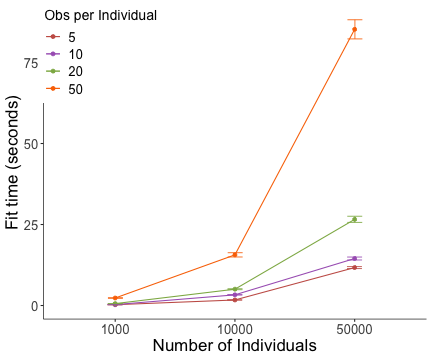

RObject{VecSxp}


In [6]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('5', '10', '20', '50'))
timedf$samplesize = factor(timedf$samplesize, levels = c('1000', '10000', '50000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


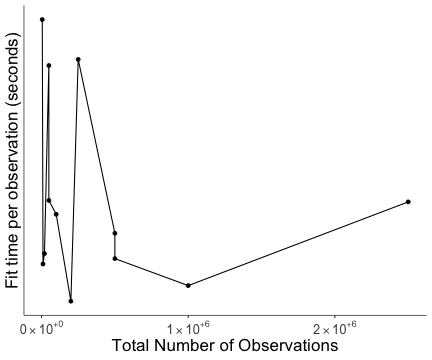

RObject{VecSxp}


In [7]:
using RCall
@rput timedf

R"""
library(scales)
library(ggplot2)
timedf$obssize <- factor(timedf$obssize, levels = c('5', '10', '20', '50'))
timedf$samplesize <- factor(timedf$samplesize, levels = c('1000', '10000', '50000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs = ggplot(timedf, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

"""

In [14]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βσ2ρcoverage = readdlm("beta_sigma_coverage_multivariate_logistic_AR50reps_sim.csv", ',')


m = 2

covdf = DataFrame(Matrix(transpose(βσ2ρcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["σ2"]; ["ρ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["σ2"]; ["ρ"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,σ2
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 1000 ni: 5,"(0.88, 0.0464231)","(0.72, 0.0641427)","(0.8, 0.0571429)","(0.0, 0.0)"
2,N: 1000 ni: 10,"(0.58, 0.0705084)","(0.84, 0.0523723)","(0.66, 0.0676727)","(0.0, 0.0)"
3,N: 1000 ni: 20,"(0.68, 0.0666395)","(0.82, 0.0548839)","(0.64, 0.0685714)","(0.0, 0.0)"
4,N: 1000 ni: 50,"(0.72, 0.0641427)","(0.66, 0.0676727)","(0.72, 0.0641427)","(0.0, 0.0)"
5,N: 10000 ni: 5,"(0.92, 0.0387562)","(0.68, 0.0666395)","(0.24, 0.0610119)","(0.0, 0.0)"
6,N: 10000 ni: 10,"(0.58, 0.0705084)","(0.72, 0.0641427)","(0.62, 0.0693409)","(0.0, 0.0)"
7,N: 10000 ni: 20,"(0.8, 0.0571429)","(0.84, 0.0523723)","(0.68, 0.0666395)","(0.0, 0.0)"
8,N: 10000 ni: 50,"(0.9, 0.0428571)","(0.9, 0.0428571)","(0.9, 0.0428571)","(0.0, 0.0)"
9,N: 50000 ni: 5,"(0.9, 0.0428571)","(0.28, 0.0641427)","(0.18, 0.0548839)","(0.0, 0.0)"


In [ ]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_logistic_AR50reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_logistic_AR50reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_logistic_AR50reps_sim.csv", ','))
βρσ2coverage_1 = readdlm("beta_sigma_coverage_multivariate_logistic_AR50reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

# βMseresultnorm = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
# τMseresultnorm = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
# ΣMseresultnorm = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
# βτcoveragenorm = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')


# samplesizesnorm = collect(1000:1000:6000)
# nsnorm = [10; 25; 50; 100; 1000]
# nsimsnorm = 1000

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, σ2mse = σ2MseResult_1, ρmse = ρMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

# p = 5; l = 5
# sample_sizesnorm = repeat(string.(samplesizesnorm), inner = nsimsnorm * length(nsnorm))
# obs_sizesnorm = repeat(string.(nsnorm), inner = nsimsnorm, outer = length(samplesizesnorm))
# msedfnorm = DataFrame(βmse = βMseresultnorm, τmse = τMseresultnorm, Σγmse = ΣMseresultnorm, 
#     samplesize = sample_sizesnorm, obssize = obs_sizesnorm)

#rename to make parsing easier for R.

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "sigmamse"
        "rhomse"
    "samplesize"
 "obssize"]);

# msedfnormR = deepcopy(msedfnorm)
# rename!(msedfnormR, ["betamse"
#     "taumse"
#     "Sigmamse"
#     "samplesize"
#  "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :sigmamse] ; msedfrobustR[!, :rhomse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 3)]...) # ; repeat(msedfnormR[!, :obssize], 3)]

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 3)]...) # ; repeat(msedfnormR[!, :samplesize], 3)]

parameters = collect([repeat(string.([:beta, :sigma, :rho]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
# ; repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = collect([repeat(["Bernoulli with LogitLink"], 3 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;
# repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

In [ ]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "sigma",y_min := 10^-5]
msedfR[parameters == "sigma",y_max := 10^1]
msedfR[parameters == "rho",y_min := 10^-5]
msedfR[parameters == "rho",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('5', '10', '20', '50'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('1000', '10000', '50000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'sigma', 'rho'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(sigma))[]), rho = expression(hat(bold(rho)))))
msedfR$robust = factor(msedfR$robust, levels = c('Bernoulli with LogitLink'),
    labels = c(expression(paste("Bernoulli with Logit Link")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [ ]:
R"""
ggsave('updated_msefacetplot_logistic_AR.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""